In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [2]:
dataset= pd.read_csv("price.csv")
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-10-01,3.997143,4.012857,3.835357,3.897143,3.327505,1296484000
1,2008-10-02,3.857500,3.885357,3.571429,3.575000,3.052449,1609364400
2,2008-10-03,3.714286,3.803571,3.380357,3.466786,2.960053,2294398400
3,2008-10-06,3.284286,3.527857,3.126429,3.505000,2.992681,2107417200
4,2008-10-07,3.588571,3.625000,3.176786,3.184286,2.718845,1878772000


Tirar a média entre o maior e menor preço da ação

In [3]:
dataset["Mean"] = (dataset["Low"] + dataset["High"])/2
dataset.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume,Mean
0,2008-10-01,3.997143,4.012857,3.835357,3.897143,3.327505,1296484000,3.924107
1,2008-10-02,3.857500,3.885357,3.571429,3.575000,3.052449,1609364400,3.728393


A função step irá fazer cada valor da média ser introduzido uma linha acima na nova coluna chamada "Actual"

In [4]:
steps=-1
dataset_for_prediction= dataset.copy()
dataset_for_prediction["Actual"]=dataset_for_prediction["Mean"].shift(steps)
dataset_for_prediction.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume,Mean,Actual
0,2008-10-01,3.997143,4.012857,3.835357,3.897143,3.327505,1296484000,3.924107,3.728393
1,2008-10-02,3.857500,3.885357,3.571429,3.575000,3.052449,1609364400,3.728393,3.591964
2,2008-10-03,3.714286,3.803571,3.380357,3.466786,2.960053,2294398400,3.591964,3.327143


Exclui os nulos

In [5]:
dataset_for_prediction=dataset_for_prediction.dropna()

In [6]:
dataset_for_prediction["Date"] =pd.to_datetime(dataset_for_prediction["Date"])
dataset_for_prediction.index= dataset_for_prediction["Date"]

Plotando a média do valor das ações

Text(0.5, 1.0, 'Tyson Opening Stock Value')

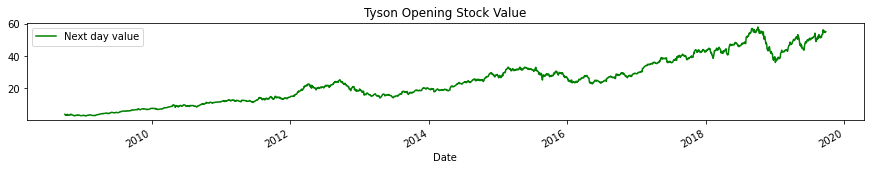

In [7]:
dataset_for_prediction["Mean"].plot(color="green", figsize=(15,2))
plt.legend(["Next day value", "Mean"])
plt.title("Tyson Opening Stock Value")

Volume de ações vendidas

Text(0.5, 1.0, 'Apple Stock Volume')

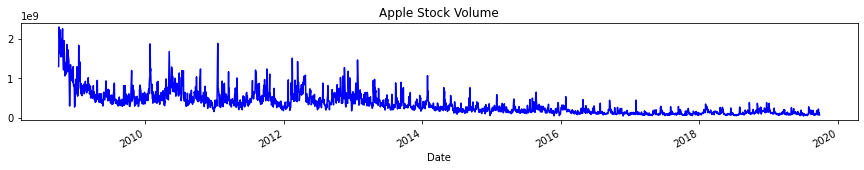

In [8]:
dataset_for_prediction["Volume"].plot(color="blue", figsize=(15,2))
plt.title("Apple Stock Volume")

Aplicando a normalização na base e separando a base em X e Y

In [9]:
from sklearn.preprocessing import MinMaxScaler
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dataset_for_prediction[["Low", "High","Open", "Close", "Volume", "Adj Close", "Mean"]])
scaled_input =pd.DataFrame(scaled_input)
X= scaled_input

In [10]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(dataset_for_prediction[["Actual"]])
scaler_output =pd.DataFrame(scaler_output)
y=scaler_output

In [11]:
X.rename(columns={0:"Low", 1:"High", 2:"Open", 3:"Close", 4:"Volume", 5:"Adj Close", 6:"Mean"}, inplace=True)
X.index=dataset_for_prediction.index
X.head(2)

,Low,High,Open,Close,Volume,Adj Close,Mean
Date,,,,,,,
2008-10-01,0.019075,0.019558,0.021177,0.019996,0.556275,0.01762,0.019318
2008-10-02,0.014246,0.017258,0.018632,0.014163,0.695398,0.01248,0.015763


In [12]:
y.rename(columns={0:"Stock Price next day"}, inplace= True)
y.index=dataset_for_prediction.index
y.head(2)

,Stock Price next day
Date,
2008-10-01,0.015763
2008-10-02,0.013284


Dividir base em treino e teste

In [13]:
train_size=int(len(dataset) *0.7)
test_size = int(len(dataset)) - train_size
train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()

Entendendo as séries temporais

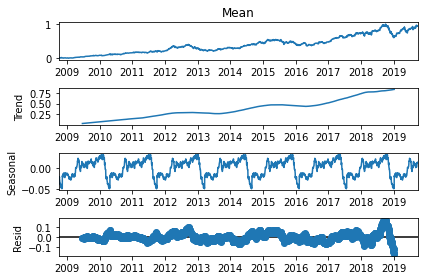

In [14]:
import statsmodels.api as sm
seas_d=sm.tsa.seasonal_decompose(X["Mean"],model="add",period=365);
fig=seas_d.plot()
fig.set_figheight(4)
plt.show()

Cria uma função para classificar se devemos aceitar o rejeitar a hipótese nula

In [15]:
from statsmodels.tsa.stattools import adfuller
def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Forte evidência contra a hipótese nula")
        print("Rejeite a hipótese nula - Estacionária")
        print("Dados são estacionários", title)
    else:
        print("Forte evidência para a hipótese nula")
        print("Aceite a hipótese nula - Estacionária")
        print("Dados não são estacionários", title)

In [16]:
y_test=y["Stock Price next day"][:train_size].dropna()
test_adf(y_test, " Stock Price")

Forte evidência para a hipótese nula
Aceite a hipótese nula - Estacionária
Dados não são estacionários  Stock Price


In [17]:
test_adf(y_test.diff(), "Stock Price")

Forte evidência contra a hipótese nula
Rejeite a hipótese nula - Estacionária
Dados são estacionários Stock Price


**Autocorrelação**: Coeficiente de correlação entre a o valor atual e seus valores passados.
A análise desse gráfico permite entender se a série é aleatória ou possui alguma tendência ou sazonalidade.
Com os valores bem próximos a 1, chegamos a conclusão que essa base tem sazonalidade
O intervalo de confiança por padrão é 95%, mostrado como essa marca azul. Observações que estão para fora da marca são consideradas estatisticamente correlacionadas.

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


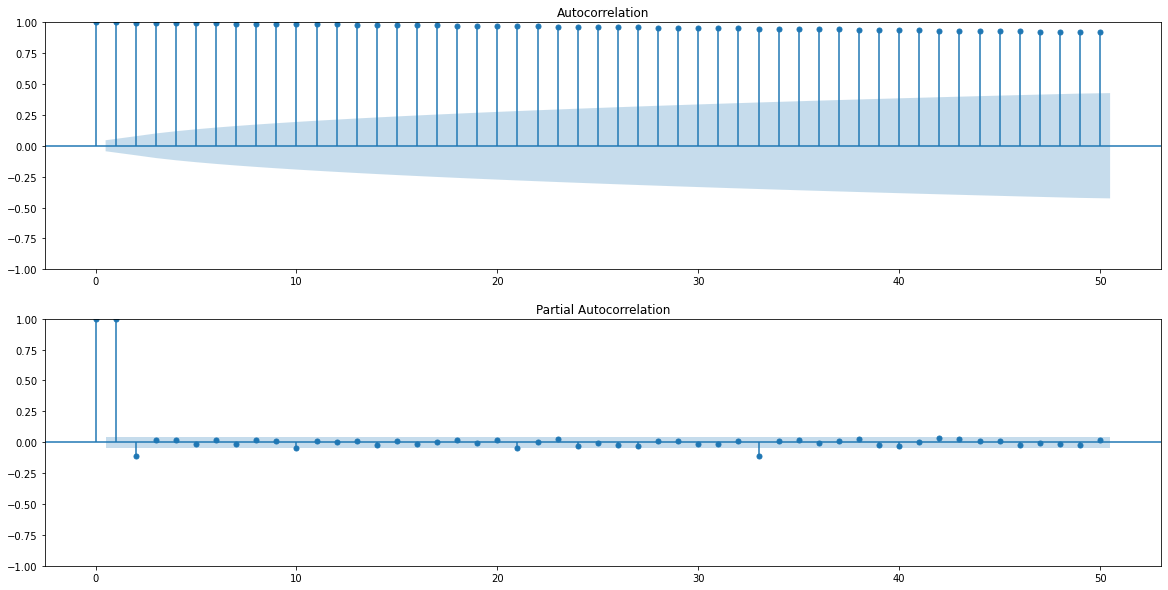

In [18]:
fig,ax= plt.subplots(2,1, figsize=(20,10))
fig=sm.tsa.graphics.plot_acf(y_test, lags=50, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_test, lags=50, ax=ax[1])
plt.show()

In [19]:
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
!pip install pmdarima


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.4 MB/s eta 0:00:00


In [21]:
from pmdarima.arima import auto_arima

In [22]:
from pmdarima.arima import auto_arima
step_wise=auto_arima(train_y, 
 exogenous= train_X,
 start_p=1, start_q=1, 
 max_p=7, max_q=7, 
 d=1, max_d=7,
 trace=True, 
 error_action="ignore", 
 suppress_warnings=True, 
 stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-15130.709, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-15077.042, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-15127.374, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-15132.095, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-15075.928, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-15130.986, Time=0.90 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-15130.275, Time=5.28 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-15131.797, Time=1.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 9.967 seconds


In [23]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1936
Model:               SARIMAX(0, 1, 1)   Log Likelihood                7569.047
Date:                Fri, 03 Mar 2023   AIC                         -15132.095
Time:                        02:05:38   BIC                         -15115.391
Sample:                             0   HQIC                        -15125.952
                               - 1936                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      1.414      0.157    -7.4e-05       0.000
ma.L1          0.1723      0.013     13.155      0.000       0.147       0.198
sigma2      2.339e-05   3.08e-07     75.974      0.000    2.28e-05     2.4e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              9198.02
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               8.10   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
train_X = np.array(train_X)
train_y = np.array(train_y)

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(train_y, 
 exog=train_X,
 order=(0,1,1),
 enforce_invertibility=False, enforce_stationarity=False)

In [26]:
results= model.fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [27]:
predictions= results.predict(start =train_size, end=train_size+test_size+(steps)-1,exog=test_X)


In [28]:
forecast_1= results.forecast(steps=test_size-1, exog=test_X)

In [29]:
act= pd.DataFrame(scaler_output.iloc[train_size:, 0])


In [30]:
act.index=test_X.index

In [31]:
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['Stock Price next day']
predictions.rename(columns={0:'Pred'}, inplace=True)

<AxesSubplot:xlabel='Date'>

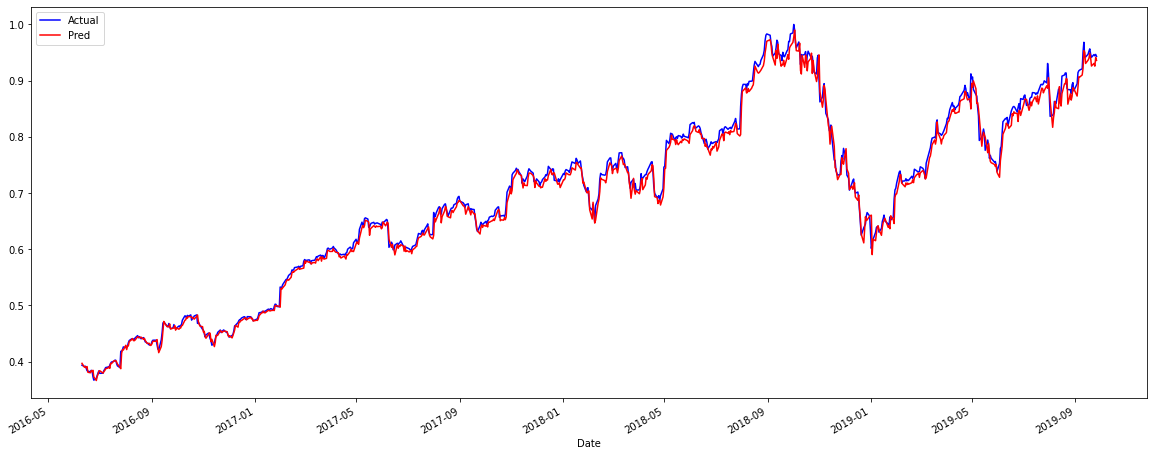

In [32]:
predictions["Actual"].plot(figsize=(20,8), legend=True, color="blue")
predictions["Pred"].plot(legend=True, color="red", figsize=(20,8))

In [33]:
actual= pd.DataFrame(scaler_output.iloc[train_size:, 0])
actual.index=test_X.index
actual.head()

,Stock Price next day
Date,
2016-06-10,0.393616
2016-06-13,0.391368
2016-06-14,0.391844
2016-06-15,0.388166
2016-06-16,0.383919


In [34]:
forecast_apple= pd.DataFrame(forecast_1)
forecast_apple.reset_index(drop=True, inplace=True)
forecast_apple.index=test_X.index
forecast_apple["Actual"] = actual['Stock Price next day']
forecast_apple.rename(columns={0:"Forecast"}, inplace=True)

<AxesSubplot:xlabel='Date'>

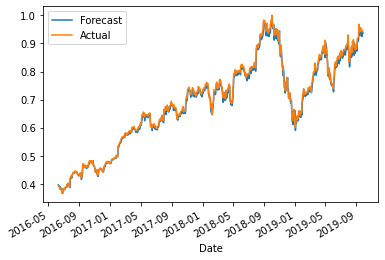

In [35]:
forecast_apple["Forecast"].plot(legend=True)
forecast_apple["Actual"].plot(legend=True)

In [36]:
from statsmodels.tools.eval_measures import rmse
error=rmse(predictions["Pred"], predictions["Actual"])
error

0.011756449988773622

In [37]:
trainPredict = sc_out.inverse_transform(predictions[["Pred"]])
testPredict = sc_out.inverse_transform(predictions[["Actual"]])